# Validation of deformable image registration for thoracic 4DCT
This Notebook contains the complete code that was used during the Bachelor End Project on validation of deformable image registration for thoracic 4DCT.

In [1]:
# Import the required libraries
import elastix
import os
import imageio
import matplotlib.pyplot as plt
from matplotlib import colors, rcParams
import seaborn as sns
import numpy as np
import SimpleITK as sitk
import scipy.stats as stats
import openpyxl

In [2]:
### Adjust the following parameters ###

# path to the end-expiration phase
fixed_image_path = r"path\images\case_{}\T50.nii.gz"

# path to the end-inspiration phase
moving_image_path = r"path\images\case_{}\T00.nii.gz"  

# path to the lung segmentation of the end-expiration phase
segmentation_path = r"path\segmentations\case_{}\T50.seg.nrrd"

# path to the landmarks
landmark_path = r"path\landmarks\case_{}\T50.txt"

# path where the visualizations will be saved
final_results_path = r"path\Results\Final results"

# path where the registration & tranformation files will be saved
path = r"path\Results\case_{}"

# parameter files evaluated
params = ['Par0007', 'Par0011', 'Par0049']

# cases of the data evaluated
cases = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]

# Physiological thresholds of the Jacobian determinant
upper_bound = 1.46
lower_bound = 0.86

# Perform registration & transformation or only visualization
registration_transformation = False

## Registration & transformation

The following cell performs registration and transformation for all the specified cases and parameter files using Elastix. Image registration of the end-expiration phase to the end-inspiration phase is performed. As Elastix defines the displacement vector field from fixed to moving image, the end-expiration and end-inspiration phase are set as fixed and moving image respectively. Using the DVF the Jacobian determinant is calculated and the landmarks are warped.

In [3]:
def Registration(fixed_image_path, moving_image_path, path, param):
    ELASTIX_PATH = r"path\\Elastix\elastix.exe"
    
    param_file_path = os.path.join(r"path\Parameter files", param + ".txt")
    result_path = os.path.join(path, param)
    transform_file_path = os.path.join(path, param, "TransformParameters.0.txt")
    output_dir_path = os.path.join(path, param)

    el = elastix.ElastixInterface(elastix_path=ELASTIX_PATH)
    
    el.register(
        fixed_image=fixed_image_path,
        moving_image=moving_image_path,
        parameters=[param_file_path],
        output_dir=result_path) 

def Transformation(moving_image_path, path, param, landmark_path):
    TRANSFORMIX_PATH = r"path\Elastix\transformix.exe"
    
    transform_file_path = os.path.join(path, param, "TransformParameters.0.txt")
    output_dir_path = os.path.join(path, param)    
    
    tr = elastix.TransformixInterface(parameters=transform_file_path, transformix_path=TRANSFORMIX_PATH) 
    transformed_image_path = tr.transform_image(moving_image_path, output_dir = output_dir_path)

    deformation_field_path = tr.deformation_field(output_dir = output_dir_path)
    jacobian_matrix_path = tr.jacobian_matrix(output_dir = output_dir_path)
    jacobian_determinant_path = tr.jacobian_determinant(output_dir = output_dir_path)
    warped_points = tr.transform_points(landmark_path, output_dir = output_dir_path)

if registration_transformation == True:
    for case in cases:
        for param in params:
            Registration(fixed_image_path.format(case), moving_image_path.format(case), path.format(case), param)
            Transformation(moving_image_path.format(case), path.format(case), param, landmark_path.format(case))
   

## Jacobian

### Jacobian overlay plots
The following cell generates overlay plots of the Jacobian determinant in coronal orientation for each parameter file for cases 1-5.

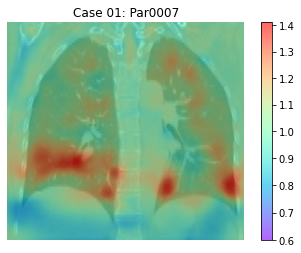

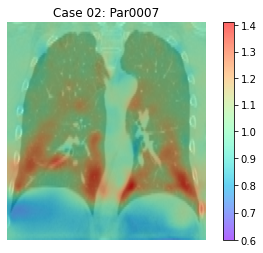

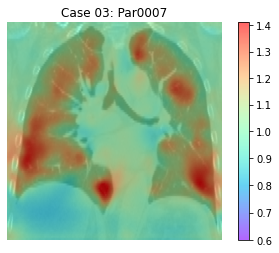

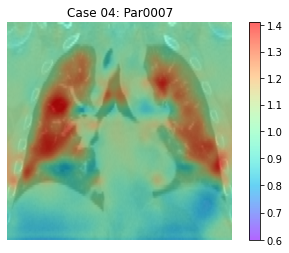

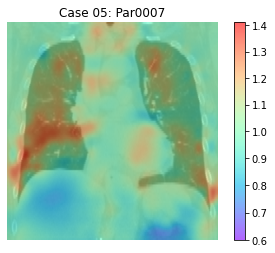

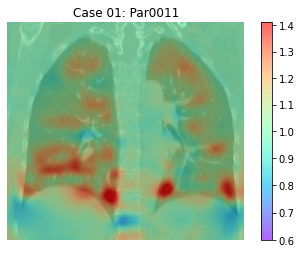

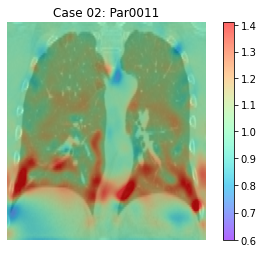

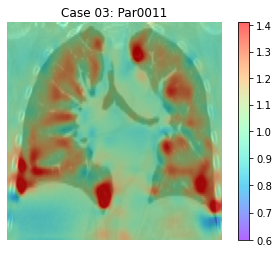

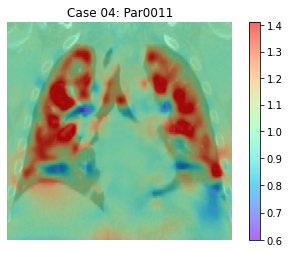

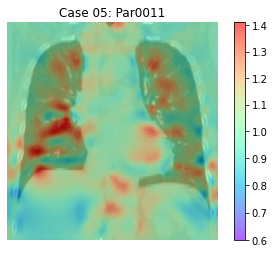

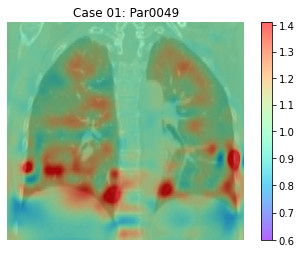

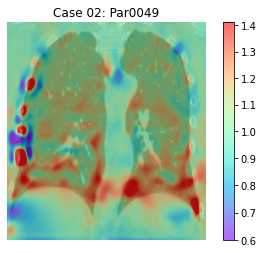

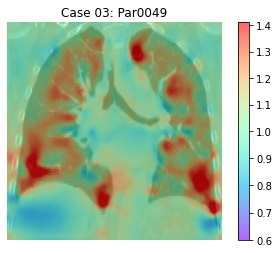

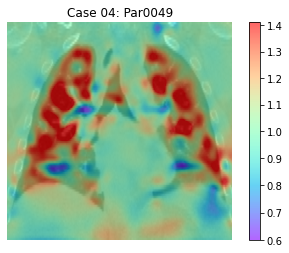

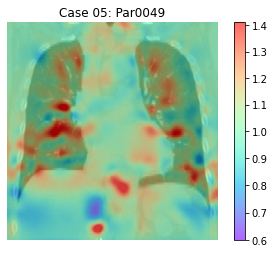

In [4]:
norms = {"Par0007": colors.TwoSlopeNorm(vmin=0.6, vcenter=1, vmax=1.41),
        "Par0049": colors.TwoSlopeNorm(vmin=0.6, vcenter=1, vmax=1.41),
         "Par0011": colors.TwoSlopeNorm(vmin=0.6, vcenter=1, vmax=1.41)}

for param in params:
    for case in cases[0:5]:
        
        jacobian = imageio.imread(os.path.join(path.format(case), param, "spatialJacobian.mhd"))

        filename_image = moving_image_path.format(case)
        itk_image = sitk.ReadImage(filename_image)
        moving_image = sitk.GetArrayViewFromImage(itk_image)

        slide = 140

        plt.imshow(moving_image[:, slide, :], cmap='gray')

        COR = jacobian[:, slide, :]

        plt.imshow(COR, cmap='rainbow', norm=norms[param], aspect=2.5, alpha=0.6)
        plt.title("Case {}: {}".format(case, param))
        plt.axis('off')
        plt.colorbar()
        plt.savefig(os.path.join(final_results_path, "case_{}_{}".format(case, param)), dpi=200, bbox_inches='tight')
        plt.show()
        

### Generate a LaTeX ready table of the distribution of the Jacobian determinant
The following cell prints a LaTeX ready table containing the minimal, maximal and median Jacobian determinant as well as the standard deviation for each parameter file and case.

In [11]:
print("Param   Case #   min   max   median   std")
data_jac_1_5 = []
for case in cases[0:5]:
    results = "Case {}".format(case)
    for param in params:
        jac = []
        
        segmentation = imageio.imread(segmentation_path.format(case))
        segmentation = np.where(segmentation > 0, 1, 0)
        segmentation = segmentation.flatten()

        jacobian = imageio.imread(os.path.join(path.format(case), param, "spatialJacobian.mhd"))
        jacobian = jacobian.flatten()

        min_ = 1000
        max_ = 0
        for i in range(len(segmentation)):
            if segmentation[i] != 0:
                jac.append(jacobian[i])
                if jacobian[i] < min_:
                    min_ = jacobian[i]
                elif jacobian[i] > max_:
                    max_ = jacobian[i]
                    
        median = np.median(jac)
        std  = np.std(jac)
        iqr = stats.iqr(jac)
        
        results += " & {:.3f} & {:.3f} & {:.3f} & {:.3f}".format(min_, max_, median, std)
    print(results)
    data_jac_1_5.append(jac)

data_jac_6_10 = []
for case in cases[5:]:
    results = "Case {}".format(case)
    for param in params:
        jac = []
        segmentation = imageio.imread(segmentation_path.format(case))
        segmentation = np.where(segmentation > 0, 1, 0)
        segmentation = segmentation.flatten()

        jacobian = imageio.imread(os.path.join(path.format(case), param, "spatialJacobian.mhd"))
        jacobian = jacobian.flatten()

        min_ = 1000
        max_ = 0        
        for i in range(len(segmentation)):
            if segmentation[i] != 0:
                jac.append(jacobian[i])
                if jacobian[i] < min_:
                    min_ = jacobian[i]
                elif jacobian[i] > max_:
                    max_ = jacobian[i]
              
        median = np.median(jac)
        std  = np.std(jac)
        iqr = stats.iqr(jac)
        
        results += " & {:.3f} & {:.3f} & {:.3f} & {:.3f}".format(min_, max_, median, std)
    print(results + "\\")
    data_jac_6_10.append(jac)


Param   Case #   min   max   median   std
Case 01 & 0.820 & 1.507 & 1.075 & 0.086 & 0.805 & 2.269 & 1.078 & 0.093 & -22.195 & 2.542 & 1.075 & 0.823
Case 02 & 0.828 & 1.418 & 1.063 & 0.072 & 0.737 & 4.403 & 1.072 & 0.117 & -0.003 & 6.012 & 1.073 & 0.161
Case 03 & 0.778 & 1.476 & 1.102 & 0.087 & 0.447 & 2.394 & 1.109 & 0.121 & 0.610 & 2.329 & 1.109 & 0.125
Case 04 & 0.799 & 1.537 & 1.128 & 0.124 & 0.224 & 2.582 & 1.144 & 0.201 & 0.190 & 2.696 & 1.142 & 0.208
Case 05 & 0.845 & 1.545 & 1.061 & 0.095 & 0.641 & 3.894 & 1.076 & 0.166 & 0.240 & 4.733 & 1.073 & 0.185
Case 06 & 0.912 & 1.366 & 1.092 & 0.087 & 0.760 & 2.381 & 1.282 & 0.188 & 0.651 & 2.991 & 1.289 & 0.213\
Case 07 & 0.852 & 1.289 & 1.107 & 0.076 & 0.642 & 2.630 & 1.201 & 0.148 & -1.909 & 8.663 & 1.196 & 0.314\
Case 08 & 0.876 & 1.416 & 1.135 & 0.097 & 0.613 & 2.945 & 1.182 & 0.190 & 0.551 & 4.764 & 1.178 & 0.223\
Case 09 & 0.915 & 1.361 & 1.131 & 0.083 & 0.772 & 1.719 & 1.167 & 0.124 & 0.685 & 2.119 & 1.166 & 0.150\
Case 10 & 0.86

## Overall folding
The following cell prints a LaTeX ready table containing the percentage of folding overall and within the lungs for each parameter file and case.

In [13]:
print("            Par0007      Par0011      Par0049")
print("Case # Overall Lungs Overall Lungs Overall Lungs")
for case in cases:
    result = "Case {}".format(case)
    for param in params:
        jacobian = imageio.imread(os.path.join(path.format(case), param, "spatialJacobian.mhd")).flatten()
        jac = np.where(jacobian < 0, 1, 0)
        percentage_folding = sum(jac)/len(jac)*100
        
        result += " & {:.3f}".format(percentage_folding)
        
        segmentation = imageio.imread(segmentation_path.format(case))
        segmentation = np.where(segmentation > 0, 1, 0)
        segmentation = segmentation.flatten()

        jacobian = imageio.imread(os.path.join(path.format(case), param, "spatialJacobian.mhd"))
        jacobian = jacobian.flatten()
        jac = np.where(jacobian < 0, 1, 0)
        jac = np.multiply(jac, segmentation)
        percentage_folding = sum(jac)/sum(segmentation)*100
        
        result += " & {:.3f}".format(percentage_folding)
    print(result) 
        

            Par0007      Par0011      Par0049
Case # Overall Lungs Overall Lungs Overall Lungs
Case 01 & 0.000 & 0.000 & 0.015 & 0.000 & 0.602 & 1.298
Case 02 & 0.000 & 0.000 & 0.001 & 0.000 & 0.008 & 0.000
Case 03 & 0.000 & 0.000 & 0.029 & 0.000 & 0.007 & 0.000
Case 04 & 0.000 & 0.000 & 0.002 & 0.000 & 0.009 & 0.000
Case 05 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000
Case 06 & 0.000 & 0.000 & 0.163 & 0.000 & 0.794 & 0.000
Case 07 & 0.000 & 0.000 & 0.068 & 0.000 & 0.968 & 0.045
Case 08 & 0.000 & 0.000 & 0.032 & 0.000 & 0.473 & 0.000
Case 09 & 0.000 & 0.000 & 0.051 & 0.000 & 0.700 & 0.000
Case 10 & 0.000 & 0.000 & 0.001 & 0.000 & 0.155 & 0.000


## Jacobian determinant out of range
### Calculate the percentage out of range within lungs
Based on the proposed physiological thresholds of the Jacobian determinant during normal resting breathing, the percentage of the Jacobian determinant out of range is calculated and plotted as a boxplot.

In [34]:
def boxplot(data_boxplot, labels, xlabel, ylabel, title, hline, outliers=False, save=False):
    # This function generates a custom-styled boxplot
    PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'blue'},
    'medianprops':{'color':'red'},
    'whiskerprops':{'linestyle':'--', 'color':'black'},
    'capprops':{'color':'black'}
    }  
    
    ax = sns.boxplot(data=data_boxplot, showfliers=outliers, color='w', **PROPS, width=0.8)

    ax.set_xticklabels(labels, rotation=0, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=12)
    if xlabel != None:
        ax.set_xlabel(xlabel, fontsize=12)
    ax.set_title(title, fontsize=14)
    if hline != None:
        ax.axhline(hline, c='gray', ls='--') 
        
    medians = [round(np.median(data_boxplot[i]), 3) for i in range(len(data_boxplot))]
    ax.text(0,medians[0] + 0.8,'{:.3f}'.format(medians[0]), 
            horizontalalignment='center',size=9,color='k')
    for xtick in ax.get_xticks()[1:]:
        ax.text(xtick,medians[xtick] + 0.4,'{:.3f}'.format(medians[xtick]), 
                horizontalalignment='center',size=9,color='k')
        
    if save == True:
        plt.savefig(os.path.join(final_results_path, "{}.png".format(title)), dpi=200, bbox_inches='tight')
        
    plt.show()
    

Par0007
Par0011
Par0049


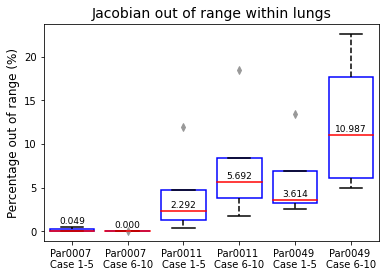

Out of range Par0007 within lungs: 0.050 % (case 1-5)
Out of range Par0007 within lungs: 0.000 % (case 6-10)
Out of range Par0011 within lungs: 2.292 % (case 1-5)
Out of range Par0011 within lungs: 5.692 % (case 6-10)
Out of range Par0049 within lungs: 3.614 % (case 1-5)
Out of range Par0049 within lungs: 10.986 % (case 6-10)


In [35]:
data_out_of_range = []
for param in params:
    percentage_out_of_range = []
    for case in cases[0:5]:
        segmentation = imageio.imread(segmentation_path.format(case))
        segmentation = np.where(segmentation > 0, 1, 0)
        segmentation = segmentation.flatten()
        
        jacobian = imageio.imread(os.path.join(path.format(case), param, "spatialJacobian.mhd")).flatten()
        jac = np.where(jacobian < lower_bound, 1, 0)
        jac += np.where(jacobian > upper_bound, 1, 0)
        jac = np.multiply(jac, segmentation)
        
        percentage_out_of_range.append(sum(jac)/sum(segmentation)*100)
    data_out_of_range.append(percentage_out_of_range)

    percentage_out_of_range = []
    for case in cases[5:]:
        segmentation = imageio.imread(segmentation_path.format(case))
        segmentation = np.where(segmentation > 0, 1, 0)
        segmentation = segmentation.flatten()
        
        jacobian = imageio.imread(os.path.join(path.format(case), param, "spatialJacobian.mhd")).flatten()
        jac = np.where(jacobian < lower_bound, 1, 0)
        jac += np.where(jacobian > upper_bound, 1, 0)
        jac = np.multiply(jac, segmentation)
        
        percentage_out_of_range.append(sum(jac)/sum(segmentation)*100)
    data_out_of_range.append(percentage_out_of_range)
    
boxplot(data_out_of_range, ['Par0007 \nCase 1-5','Par0007 \nCase 6-10', 'Par0011 \nCase 1-5', 'Par0011 \nCase 6-10', 
                            'Par0049 \nCase 1-5', 'Par0049 \nCase 6-10'], None, 'Percentage out of range (%)', 
                            'Jacobian out of range within lungs', None, outliers=True, save=True)

medians = [round(np.median(data_out_of_range[i]), 4) for i in range(len(data_out_of_range))]
print('Out of range Par0007 within lungs: {:.3f} % (case 1-5)'.format(medians[0]))
print('Out of range Par0007 within lungs: {:.3f} % (case 6-10)'.format(medians[1]))
print('Out of range Par0011 within lungs: {:.3f} % (case 1-5)'.format(medians[2]))
print('Out of range Par0011 within lungs: {:.3f} % (case 6-10)'.format(medians[3]))
print('Out of range Par0049 within lungs: {:.3f} % (case 1-5)'.format(medians[4]))
print('Out of range Par0049 within lungs: {:.3f} % (case 6-10)'.format(medians[5]))  

# TRE

In [45]:
def importPoints(case, param):
    # This function imports the initial and transformed landmarks and returns a dictionary 
    # with each key containing the physical coordinates of the fixed, moving and transformed landmarks
    # Input:
    #    - case to open the landmarks of
    #    - param to open the landmarks of
    output_points_path = r"path\Results\case_{}\{}\outputpoints.txt".format(case, param)
    fixed_points_path = r"path\landmarks\case_{}\T00.txt".format(case)
    fixed_image_path = r"path\images\case_{}\T00.nii.gz".format(case)
    
    itk_fixed_image = sitk.ReadImage(fixed_image_path)
    fixed_image = sitk.GetArrayViewFromImage(itk_fixed_image)
    spacing = itk_fixed_image.GetSpacing()

    landmarks = {}
    
    lines = open(fixed_points_path).readlines()
    i = 1
    for line in lines:
        splitted_line = line.rstrip().split('\t')
        landmarks[i] = [[float(splitted_line[j])*spacing[j] for j in range(len(splitted_line))]]
        i += 1
    
    lines = open(output_points_path).readlines()

    i = 1
    for line in lines:
        splitted_line = [line.split(';')[2][16:-4].split(' '), line.split(';')[4][17:-3].split(' ')]
        landmarks[i].append([abs(float(splitted_line[0][j])) for j in range(len(splitted_line[0]))])
        landmarks[i].append([abs(float(splitted_line[1][j])) for j in range(len(splitted_line[1]))])
        i += 1
    
    return landmarks

def TRE(cases, params):
    # This function calculates the magnitude of the TRE and return a list of TRE for each landmark
    # Input: 
    #    - cases to calculate the TRE for
    #    - params to calculate the TRE for
    # Output:
    #    - list with lists containing the TRE per landmark
    data_tre = []
    
    x = 1
    for param in params:
        data_init = []
        data_transf = []
        for case in cases:
            landmarks = importPoints(case, param)
            
            TRE_init = np.empty((375,))
            TRE_transf = np.empty((375,))

            j = 0
            for i in list(landmarks.keys()):
                TRE_init[j] = np.sqrt(sum(np.array(landmarks[i][0]) - np.array(landmarks[i][1]))**2)
                TRE_transf[j] = np.sqrt(sum(np.array(landmarks[i][0]) - np.array(landmarks[i][2]))**2)
                j += 1                   
            
            data_init.extend(TRE_init)
            data_transf.extend(TRE_transf)
            
        if x == 1:
            data_tre.append(data_init)
        data_tre.append(data_transf)
        x += 1

    return data_tre
            
    
def boxplot(data_tre, title, labels, save=True):
    # Generates a custom-styled boxplot for visualizing the magnitude of the TRE
    # Input: 
    #    - list of lists containing the magnitude of the TRE per parameter
    #    - title of the plot (and filename)
    #    - labels of the parameters (x-axis)
    #    - option to save the plot
    # Output:
    #    - custom styled boxplot (and png file of plot when saved)
    rcParams['figure.figsize'] = 4, 6
    sns.set_style("white")
    PROPS = {
        'boxprops':{'facecolor':'none', 'edgecolor':'blue'},
        'medianprops':{'color':'red'},
        'whiskerprops':{'linestyle':'--', 'color':'black'},
        'capprops':{'color':'black'}
    }    
    ax = sns.boxplot(data = data_tre, showfliers = True, **PROPS, width=0.8)
    ax.set_title("Magnitude TRE: Cases {}".format(title), fontsize=14)
    ax.set_ylabel('TRE (mm)', fontsize=14)
    ax.set_xticklabels(labels, rotation=45, fontsize=12)
    
    medians = [round(np.median(data_tre[i]), 3) for i in range(len(data_tre))]
    for xtick in ax.get_xticks()[0:2]:
        ax.text(xtick,medians[xtick] + 0.4,'{:.3f}'.format(medians[xtick]), 
                horizontalalignment='center',size=9,color='k')
    for xtick in ax.get_xticks()[2:]:
        ax.text(xtick,medians[xtick] + 0.2,'{:.3f}'.format(medians[xtick]), 
                horizontalalignment='center',size=9,color='k')
    
    if save == True:
        plt.savefig(os.path.join(final_results_path, "Magnitude TRE Cases{}.png".format(title)), 
                    dpi=200, bbox_inches="tight")
    plt.show()
    

## Visualization of TRE
### Magnitude of TRE for cases 1-5
The following cell creates a boxplot of the initial magnitude of the TRE before registration and the magnitude of the TRE after registration for each parameter for cases 1-5.

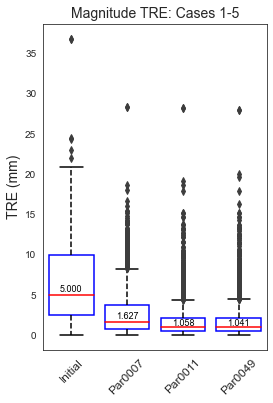

In [60]:
cases_batch_1_5 = cases[0:5]
title_1_5 = "1-5"
    
SI_1_5 = []
AP_1_5 = []
LAT_1_5 = []
for case in cases_batch_1_5:
    points = importPoints(case, 'Par0007')
    for key in points:
        SI_1_5.append(points[key][0][2])
        AP_1_5.append(points[key][0][1])
        LAT_1_5.append(points[key][0][0])
        
magnitude_TRE_1_5 = TRE(cases_batch_1_5, params)

labels = ["Initial", "Par0007", "Par0011", "Par0049"]
ax = sns.boxplot(data = magnitude_TRE_1_5, showfliers = True, **PROPS, width=0.8)
ax.set_title("Magnitude TRE: Cases 1-5", fontsize=14)
ax.set_ylabel('TRE (mm)', fontsize=14)
ax.set_xticklabels(labels, rotation=45, fontsize=12)

medians = [round(np.median(magnitude_TRE_1_5[i]), 3) for i in range(len(magnitude_TRE_1_5))]
for xtick in ax.get_xticks()[0:2]:
    ax.text(xtick,medians[xtick] + 0.4,'{:.3f}'.format(medians[xtick]), 
            horizontalalignment='center',size=9,color='k')
for xtick in ax.get_xticks()[2:]:
    ax.text(xtick,medians[xtick] + 0.1,'{:.3f}'.format(medians[xtick]), 
            horizontalalignment='center',size=9,color='k')

plt.savefig(os.path.join(final_results_path, "Magnitude TRE Cases 1-5.png"), dpi=200, bbox_inches="tight")
plt.show()

### Magnitude of TRE for cases 6-10
The following cell creates a boxplot of the initial magnitude of the TRE before registration and the magnitude of the TRE after registration for each parameter for cases 6-10.

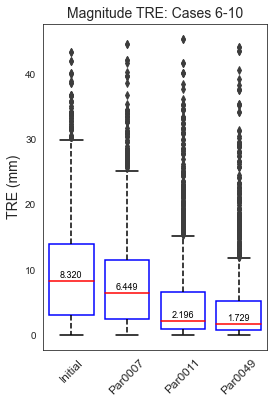

Initial Cases 6-10: median TRE = 8.320
Par0007 Cases 6-10: median TRE = 6.449
Par0011 Cases 6-10: median TRE = 2.196
Par0049 Cases 6-10: median TRE = 1.729


In [57]:
cases_batch_6_10 = cases[5:]
title_6_10 = "6-10"

SI_6_10 = []
AP_6_10 = []
LAT_6_10 = []
for case in cases_batch_6_10:
    points = importPoints(case, 'Par0007')
    for key in points:
        SI_6_10.append(points[key][0][2])
        AP_6_10.append(points[key][0][1])
        LAT_6_10.append(points[key][0][0])
        
magnitude_TRE_6_10 = TRE(cases_batch_6_10, params)

labels = ["Initial", "Par0007", "Par0011", "Par0049"]
ax = sns.boxplot(data = magnitude_TRE_6_10, showfliers = True, **PROPS, width=0.8)
ax.set_title("Magnitude TRE: Cases 6-10", fontsize=14)
ax.set_ylabel('TRE (mm)', fontsize=14)
ax.set_xticklabels(labels, rotation=45, fontsize=12)

medians = [round(np.median(magnitude_TRE_6_10[i]), 3) for i in range(len(magnitude_TRE_6_10))]
for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + 0.5,'{:.3f}'.format(medians[xtick]), 
            horizontalalignment='center',size=9,color='k')

plt.savefig(os.path.join(final_results_path, "Magnitude TRE Cases 6-10.png"), dpi=200, bbox_inches="tight")
plt.show()
          
print('Initial Cases {}: median TRE = {:.3f}'.format(title_6_10, np.median(magnitude_TRE_6_10[0])))
print('Par0007 Cases {}: median TRE = {:.3f}'.format(title_6_10, np.median(magnitude_TRE_6_10[1])))
print('Par0011 Cases {}: median TRE = {:.3f}'.format(title_6_10, np.median(magnitude_TRE_6_10[2])))
print('Par0049 Cases {}: median TRE = {:.3f}'.format(title_6_10, np.median(magnitude_TRE_6_10[3])))


## Spatial distribution magnitude of TRE
### Magnitude TRE in medial-lateral direction
The following cell creates a scatterplot of the magnitude of the TRE in the medial-lateral direction of the lungs. The x-axis indicates the position along the axis in physical coordinates. The y-axis indicates the magnitude of the TRE in mm.

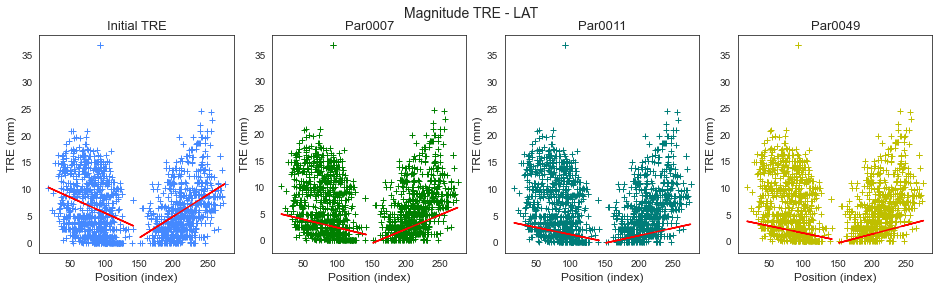

In [13]:
magnitude_TRE = magnitude_TRE_1_5.copy()
title = title_1_5

LAT = LAT_1_5
AP = AP_1_5
SI = SI_1_5

LAT_left = []
TRE_left = [[], [], [], []]
LAT_right = []
TRE_right = [[], [], [], []]

for i in range(len(LAT)):
    if LAT[i] < 150:
        LAT_left.append(LAT[i])
        for j in range(4):
            TRE_left[j].append(magnitude_TRE[j][i])
    if LAT[i] > 150:
        LAT_right.append(LAT[i])
        for j in range(4):
            TRE_right[j].append(magnitude_TRE[j][i])

fig, ax = plt.subplots(1,4, figsize=(16,4))
ax[0].scatter(LAT_left, TRE_left[0], color='#4589ff', marker='+', linewidth=1)
ax[0].scatter(LAT_right, TRE_right[0], color='#4589ff', marker='+', linewidth=1)
ax[0].set_title('Initial TRE', fontsize=13)
ax[0].set_xlabel('Position (index)', fontsize=12)
ax[0].set_ylabel('TRE (mm)', fontsize=12)
m, b = np.polyfit(LAT_left, TRE_left[0], 1)
ax[0].plot(LAT_left, m*np.array(LAT_left) + b, 'r-')
m, b = np.polyfit(LAT_right, TRE_right[0], 1)
ax[0].plot(LAT_right, m*np.array(LAT_right) + b, 'r-')


ax[1].plot(LAT_left, TRE_left[0], 'g+')
ax[1].plot(LAT_right, TRE_right[0], 'g+')
ax[1].set_title('Par0007', fontsize=13)
ax[1].set_xlabel('Position (index)', fontsize=12)
ax[1].set_ylabel('TRE (mm)', fontsize=12)
m, b = np.polyfit(LAT_left, TRE_left[1], 1)
ax[1].plot(LAT_left, m*np.array(LAT_left) + b, 'r-')
m, b = np.polyfit(LAT_right, TRE_right[1], 1)
ax[1].plot(LAT_right, m*np.array(LAT_right) + b, 'r-')

ax[2].scatter(LAT_left, TRE_left[0], color='#007d79', marker='+', linewidth=1)
ax[2].scatter(LAT_right, TRE_right[0], color='#007d79', marker='+', linewidth=1)
ax[2].set_title('Par0011', fontsize=13)
ax[2].set_xlabel('Position (index)', fontsize=12)
ax[2].set_ylabel('TRE (mm)', fontsize=12)
m, b = np.polyfit(LAT_left, TRE_left[2], 1)
ax[2].plot(LAT_left, m*np.array(LAT_left) + b, 'r-')
m, b = np.polyfit(LAT_right, TRE_right[2], 1)
ax[2].plot(LAT_right, m*np.array(LAT_right) + b, 'r-')


ax[3].plot(LAT_left, TRE_left[0], 'y+')
ax[3].plot(LAT_right, TRE_right[0], 'y+')
ax[3].set_title('Par0049', fontsize=13)
ax[3].set_xlabel('Position (index)', fontsize=12)
ax[3].set_ylabel('TRE (mm)', fontsize=12)
m, b = np.polyfit(LAT_left, TRE_left[3], 1)
ax[3].plot(LAT_left, m*np.array(LAT_left) + b, 'r-')
m, b = np.polyfit(LAT_right, TRE_right[3], 1)
ax[3].plot(LAT_right, m*np.array(LAT_right) + b, 'r-')

fig.suptitle('Magnitude TRE - LAT', fontsize=14)
plt.savefig(os.path.join(final_results_path, "TRE_LAT_cases{}.png".format(title)), dpi=200, bbox_inches="tight")
plt.show()

### Magnitude TRE in anterior-posterior direction
The following cell creates a scatterplot of the magnitude of the TRE in the anterior-posterior direction of the lungs. The x-axis indicates the position along the axis in physical coordinates. The y-axis indicates the magnitude of the TRE in mm.

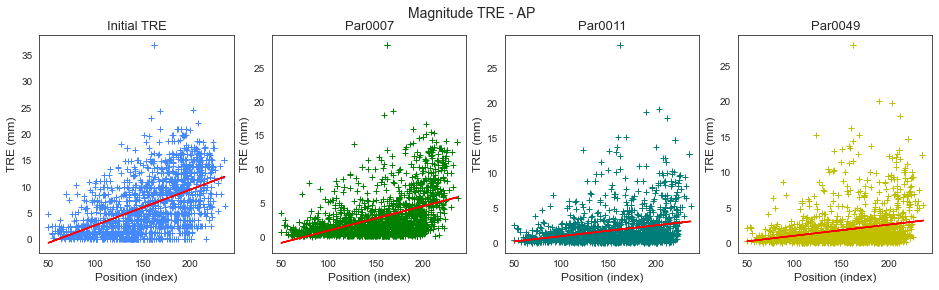

In [14]:
fig, ax = plt.subplots(1,4, figsize=(16,4))
ax[0].scatter(AP, magnitude_TRE[0], color='#4589ff', marker='+', linewidth=1)
ax[0].set_title('Initial TRE', fontsize=13)
ax[0].set_xlabel('Position (index)', fontsize=12)
ax[0].set_ylabel('TRE (mm)', fontsize=12)
m, b = np.polyfit(AP, magnitude_TRE[0], 1)
ax[0].plot(AP, m*np.array(AP) + b, 'r-')

ax[1].plot(AP, magnitude_TRE[1], 'g+')
ax[1].set_title('Par0007', fontsize=13)
ax[1].set_xlabel('Position (index)', fontsize=12)
ax[1].set_ylabel('TRE (mm)', fontsize=12)
m, b = np.polyfit(AP, magnitude_TRE[1], 1)
ax[1].plot(AP, m*np.array(AP) + b, 'r-')

ax[2].scatter(AP, magnitude_TRE[2], color='#007d79', marker='+', linewidth=1)
ax[2].set_title('Par0011', fontsize=13)
ax[2].set_xlabel('Position (index)', fontsize=12)
ax[2].set_ylabel('TRE (mm)', fontsize=12)
m, b = np.polyfit(AP, magnitude_TRE[2], 1)
ax[2].plot(AP, m*np.array(AP) + b, 'r-')

ax[3].plot(AP, magnitude_TRE[3], 'y+')
ax[3].set_title('Par0049', fontsize=13)
ax[3].set_xlabel('Position (index)', fontsize=12)
ax[3].set_ylabel('TRE (mm)', fontsize=12)
m, b = np.polyfit(AP, magnitude_TRE[3], 1)
ax[3].plot(AP, m*np.array(AP) + b, 'r-')

fig.suptitle('Magnitude TRE - AP', fontsize=14)
plt.savefig(os.path.join(final_results_path, "TRE_AP_cases{}.png".format(title)), dpi=200, bbox_inches="tight")
plt.show()

### Magnitude TRE in superior-inferior direction
The following cell creates a scatterplot of the magnitude of the TRE in the superior-inferior direction of the lungs. The x-axis indicates the position along the axis in physical coordinates. The y-axis indicates the magnitude of the TRE in mm.

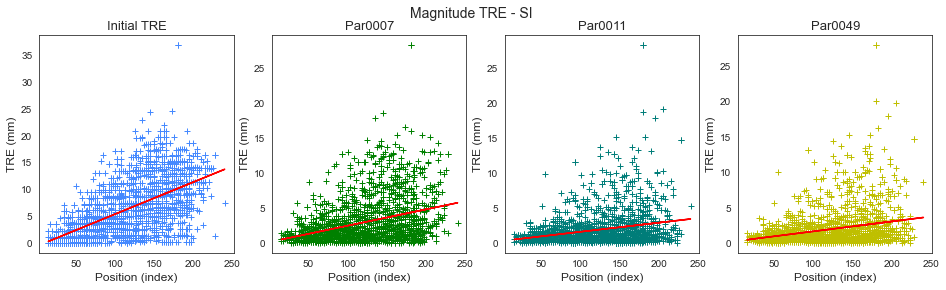

In [15]:
fig, ax = plt.subplots(1,4, figsize=(16,4))
ax[0].scatter(SI, magnitude_TRE[0], color='#4589ff', marker='+', linewidth=1)
ax[0].set_title('Initial TRE', fontsize=13)
ax[0].set_xlabel('Position (index)', fontsize=12)
ax[0].set_ylabel('TRE (mm)', fontsize=12)
m, b = np.polyfit(SI, magnitude_TRE[0], 1)
ax[0].plot(SI, m*np.array(SI) + b, 'r-')

ax[1].plot(SI, magnitude_TRE[1], 'g+')
ax[1].set_title('Par0007', fontsize=13)
ax[1].set_xlabel('Position (index)', fontsize=12)
ax[1].set_ylabel('TRE (mm)', fontsize=12)
m, b = np.polyfit(SI, magnitude_TRE[1], 1)
ax[1].plot(SI, m*np.array(SI) + b, 'r-')

ax[2].scatter(SI, magnitude_TRE[2], color='#007d79', marker='+', linewidth=1)
ax[2].set_title('Par0011', fontsize=13)
ax[2].set_xlabel('Position (index)', fontsize=12)
ax[2].set_ylabel('TRE (mm)', fontsize=12)
m, b = np.polyfit(SI, magnitude_TRE[2], 1)
ax[2].plot(SI, m*np.array(SI) + b, 'r-')

ax[3].plot(SI, magnitude_TRE[3], 'y+')
ax[3].set_title('Par0049', fontsize=13)
ax[3].set_xlabel('Position (index)', fontsize=12)
ax[3].set_ylabel('TRE (mm)', fontsize=12)
m, b = np.polyfit(SI, magnitude_TRE[3], 1)
ax[3].plot(SI, m*np.array(SI) + b, 'r-')

fig.suptitle("Magnitude TRE - SI", fontsize=14)
plt.savefig(os.path.join(final_results_path, "TRE_SI_cases{}.png".format(title)), dpi=200, bbox_inches="tight")
plt.show()